In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run this block once and then reload
## No need to run after reloading

In [1]:
# Run once and reload
# No need to run after reloading
!pip install torchdyn
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 798 kB 31.9 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 193 kB 68.4 MB/s 
     |████████████████████████████████| 1.6 MB 55.6 MB/s 
     |████████████████████████████████| 529 kB 53.4 MB/s 
     |████████████████████████████████| 87 kB 8.6 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=393dacb99c39d32b357f6fc7d361df90b8ef54a1c09d4231ac1af7dadc353494
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=736f43cf9505999001c6b9c4ed5fcbc204d7ae48fcfa54828447d7d4edde0b1e
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1f

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.integrate import solve_ivp
from torch.optim import AdamW
from torchdyn.core import ODEProblem
from tqdm import tqdm

In [3]:
def seed_everything(seed=1234):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

In [4]:
seed_everything()

# Training Arguments

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###################################
# Argments
IS_RESTART = False
P_CUTOFF = 0.0
N_EPOCH = 1000000
N_PLOT = 100
DATASIZE = 100
TSTEP = 0.4
N_EXP_TRAIN = 20
N_EXP_TEST = 10
N_EXP = N_EXP_TRAIN + N_EXP_TEST
NOISE = 5.0e-2
NS = 5
NR = 4
K = torch.tensor([0.1, 0.2, 0.13, 0.3])
ATOL = 1e-5
RTOL = 1e-2

MAXITERS = 10000

LB = 1.0e-5
UB = 1.0e1

B0 = -10

####################################

# Directories to store checkpoints and figures

In [ ]:
# Make sure to not put a '/' after the folder name
BASE_DIR = '/content/drive/MyDrive/CRNN'
SAVE_EXP_DIR = "figs_py"  
CHECKPOINT_DIR= "checkpoint"
CHECKPOINT_SAVE_PATH = f"{BASE_DIR}/{CHECKPOINT_DIR}/mymodel.pt" 
LOSS_SAVE_PATH = f"{BASE_DIR}/{SAVE_EXP_DIR}/loss.png"

In [6]:
if os.path.exists(BASE_DIR) == False:
  os.mkdir(BASE_DIR)
if os.path.exists(f'{BASE_DIR}/{SAVE_EXP_DIR}') == False:
  os.mkdir(f'{BASE_DIR}/{SAVE_EXP_DIR}')
if os.path.exists(f'{BASE_DIR}/{CHECKPOINT_DIR}') == False:
  os.mkdir(f'{BASE_DIR}/{CHECKPOINT_DIR}')

In [7]:
def trueODEfunc(t, y, k):
  dydt_0 = -2 * k[0] * y[0] ** 2 - k[1] * y[0]
  dydt_1 = k[0] * y[0] ** 2 - k[3] * y[1] * y[3]
  dydt_2 = k[1] * y[0] - k[2] * y[2]
  dydt_3 = k[2] * y[2] - k[3] * y[1] * y[3]
  dydt_4 = k[3] * y[1] * y[3]
  return [dydt_0, dydt_1, dydt_2, dydt_3, dydt_4]

In [8]:
def max_min(ode_data):
  return torch.amax(ode_data, dim=1) - torch.amin(ode_data, dim=1) + LB

In [9]:
def p2vec(p):
    w_b = p[:NR] + B0
    w_out = torch.reshape(p[NR:], (NR, NS)).transpose(0, 1)
    w_in = torch.clamp(-w_out, 0, 2.5)
    return w_in, w_b, w_out


def display_p(p):
    w_in, w_b, w_out = p2vec(p)
    print("species (column) reaction (row)")
    print("w_in")
    print(w_in.transpose(0, 1))
    print("\nw_b")
    print(w_b)
    print("\nw_out")
    print(w_out.transpose(0, 1))
    print("\n\n")

In [10]:
class CRNN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.p = torch.nn.Parameter(torch.randn(NR * (NS + 1)) * 1.0e-1)

    def forward(self, x):
        w_in, w_b, w_out = self._p2vec()
        w_in_x = w_in.transpose(0, 1) @ torch.log(torch.clamp(x, min=LB, max=UB))
        return w_out @ torch.exp(w_in_x + w_b)

    def _p2vec(self):
        w_b = self.p[:NR] + B0
        w_out = torch.reshape(self.p[NR:], (NR, NS)).transpose(0, 1)
        w_in = torch.clamp(-w_out, 0, 2.5)
        return w_in, w_b, w_out

In [11]:
def plot_losses(list_loss_train, list_loss_test):
    fig, ax = plt.subplots(figsize=(5, 2.7), layout="constrained")
    ax.plot(list_loss_train, label="train")
    ax.plot(list_loss_test, label="val")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.grid(True)
    ax.set_title("Loss Plots")  # Add a title to the axes.
    ax.legend()
    # Add a legend.
    fig.savefig(LOSS_SAVE_PATH)

In [12]:
def plot_exps(tsteps, ode_data_list, pred, i_exp):
    species = ["A", "B", "C", "D", "E"]

    ncols = NS - int(NS / 2)
    nrows = int(NS / 2)
    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(20.5, 12.5), layout="constrained"
    )

    ode_index = 0
    for row in range(nrows):
        for col in range(ncols):
            if ode_index == NS:
                break
            ode_data = ode_data_list[i_exp, ode_index, :]
            axs[row, col].scatter(tsteps, ode_data, label="Exp", c="orange", marker="x")
            axs[row, col].plot(tsteps, pred[ode_index], label="CRNN-ODE")
            axs[row, col].set_xlabel("Time")
            axs[row, col].set_ylabel(f"Concentration of {species[ode_index]}")

            if ode_index == 0:
                axs[row, col].legend()

            if row == 1 and col == 2:
                axs[row, col].get_xaxis().set_visible(False)
                axs[row, col].get_yaxis().set_visible(False)

            ode_index += 1

    fig.savefig(f"{BASE_DIR}/{SAVE_EXP_DIR}/i_exp_{i_exp}.png")

In [13]:
def main():
    seed_everything()

    # Generate Datasets
    u0_list = torch.rand((N_EXP, NS)).reshape((NS, N_EXP)).transpose(0, 1)
    u0_list[:, 0:2] += 2.0e-1
    u0_list[:, 2:] = 0.0
    tspan = torch.tensor([0.0, DATASIZE * TSTEP])
    tsteps = torch.linspace(tspan[0], tspan[1], DATASIZE)
    ode_data_list = torch.zeros((N_EXP, NS, DATASIZE))
    std_list = torch.tensor([])

    # push ode data to std list
    print("Calculating y_std...")
    for i in range(N_EXP):
        u0 = u0_list[i]
        ode_data = solve_ivp(trueODEfunc, tspan.numpy(), u0.numpy(), t_eval=tsteps.numpy(), args=(K.numpy(),))
        ode_data = ode_data.y
        ode_data = torch.tensor(ode_data)
        # The reshape and the transpose makes the alignment same with julia
        ode_data += (
            torch.rand((ode_data.shape))
            .reshape((ode_data.shape[1], -1))
            .transpose(0, 1)
            * ode_data
            * NOISE
        )
        ode_data_list[i] = ode_data
        std_list = torch.cat((std_list, ode_data.unsqueeze(dim=0)))

    y_std = torch.max(std_list)
    print(f"y_std: \t{y_std}")

    u0 = u0_list[0]
    p = torch.randn(NR * (NS + 1)) * 1.0e-1

    model = CRNN()
    model_prob = ODEProblem(model, solver="rk4", atol=ATOL, rtol=RTOL).to(device)

    criterion = torch.nn.L1Loss()
    optimizer = AdamW(model_prob.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1.0e-8)

    epoch_start = 0
    if IS_RESTART:
        checkpoint = torch.load(CHECKPOINT_SAVE_PATH)
        model_prob.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch_start = checkpoint["epoch"]
        loss_train = checkpoint["loss_train"]
        loss_test = checkpoint["loss_test"]

    list_loss_train = []
    list_loss_test = []

    tsteps = tsteps.to(device)
    ode_data_list = ode_data_list.to(device)
    y_std = y_std.to(device)

    for num_iter, epoch in enumerate(tqdm(range(epoch_start, N_EPOCH))):
        loss_epoch = torch.zeros(N_EXP).to(device)

        model_prob.train()
        for i_exp in torch.randperm(N_EXP_TRAIN):
            u_train = u0_list[i_exp].to(device)
            t_train, y_hat = model_prob(u_train, tsteps)
            y_hat = y_hat.transpose(0, 1)

            loss = criterion(ode_data_list[i_exp] / y_std, y_hat / y_std)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch[i_exp] = loss

        model_prob.eval()
        for i_exp_eval in range(N_EXP_TRAIN, N_EXP):
            u_eval = u0_list[i_exp_eval].to(device)
            t_eval, y_hat_eval = model_prob(u_eval, tsteps)
            y_hat_eval = y_hat_eval.transpose(0, 1)

            loss_eval = criterion(ode_data_list[i_exp_eval] / y_std, y_hat_eval / y_std)
            loss_epoch[i_exp_eval] = loss_eval

        loss_train = torch.mean(loss_epoch[:N_EXP_TRAIN])
        loss_test = torch.mean(loss_epoch[N_EXP_TRAIN:])

        print(f"\nLoss Train: \t{loss_train.item()}")
        print(f"Loss Test: \t{loss_test.item()}")

        list_loss_train.append(loss_train.item())
        list_loss_test.append(loss_test.item())

        if num_iter % N_PLOT == 0:
            display_p(next(model_prob.parameters()).cpu().detach())

            print(f"Minimum Loss Train: \t{min(list_loss_train)}")
            print(f"Minimum Loss Test: \t{min(list_loss_test)}")

            # Plot exp figures
            i_exp = np.random.permutation(N_EXP)[0]
            model_prob.eval()
            i_exp_data = u0_list[i_exp].to(device)
            _, y_hat_exp = model_prob(i_exp_data, tsteps)
            y_hat_exp = y_hat_exp.transpose(0, 1)
            # plot_exps(tsteps, ode_data_list, y_hat_exp.detach().numpy(), i_exp)
            plot_exps(
                tsteps.cpu().numpy(), ode_data_list.cpu().numpy(), y_hat_exp.detach().cpu().numpy(), i_exp
            )

            # Save loss
            plot_losses(list_loss_train, list_loss_test)

            # Save checkpoint
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model_prob.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss_train": loss_train.item(),
                    "loss_test": loss_test.item(),
                },
                CHECKPOINT_SAVE_PATH,
            )


Calculating y_std...
y_std: 	1.3053218965434232
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")



Loss Train: 	0.18827998638153076
Loss Test: 	0.2097943127155304
species (column) reaction (row)
w_in
tensor([[0.0961, 0.2685, 0.0556, 0.1449, 0.0000],
        [0.0000, 0.0028, 0.1319, 0.0000, 0.1570],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1443, 0.0067, 0.0865, 0.0000, 0.1118]])

w_b
tensor([-10.0073,  -9.8461,  -9.9648, -10.0969])

w_out
tensor([[-0.0961, -0.2685, -0.0556, -0.1449,  0.0348],
        [ 0.0290, -0.0028, -0.1319,  0.0542, -0.1570],
        [ 0.1221,  0.0336,  0.0476,  0.0423,  0.0692],
        [-0.1443, -0.0067, -0.0865,  0.0460, -0.1118]])



Minimum Loss Train: 	0.18827998638153076
Minimum Loss Test: 	0.2097943127155304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """
 20%|██        | 2/10 [00:19<01:14,  9.37s/it]


Loss Train: 	0.18826031684875488
Loss Test: 	0.2097712755203247


 30%|███       | 3/10 [00:27<01:01,  8.76s/it]


Loss Train: 	0.18823076784610748
Loss Test: 	0.20973089337348938


 40%|████      | 4/10 [00:36<00:52,  8.79s/it]


Loss Train: 	0.18817925453186035
Loss Test: 	0.20966295897960663


 50%|█████     | 5/10 [00:43<00:41,  8.39s/it]


Loss Train: 	0.18810681998729706
Loss Test: 	0.2095838040113449


 60%|██████    | 6/10 [00:51<00:32,  8.18s/it]


Loss Train: 	0.18803444504737854
Loss Test: 	0.20951321721076965


 70%|███████   | 7/10 [00:59<00:24,  8.04s/it]


Loss Train: 	0.18797914683818817
Loss Test: 	0.20946104824543


 80%|████████  | 8/10 [01:07<00:15,  7.93s/it]


Loss Train: 	0.18793092668056488
Loss Test: 	0.20941101014614105


 90%|█████████ | 9/10 [01:14<00:07,  7.87s/it]


Loss Train: 	0.18788449466228485
Loss Test: 	0.20935893058776855

Loss Train: 	0.18783552944660187
Loss Test: 	0.2093055695295334
species (column) reaction (row)
w_in
tensor([[0.3115, 0.4907, 0.0000, 0.0000, 0.0000],
        [0.1289, 0.1601, 0.1361, 0.0000, 0.1573],
        [0.0469, 0.1298, 0.0000, 0.0000, 0.0000],
        [0.3690, 0.2317, 0.0000, 0.0000, 0.0000]])

w_b
tensor([-9.7041, -9.9179, -9.6967, -9.8076])

w_out
tensor([[-0.3115, -0.4907,  0.1489,  0.0467,  0.3004],
        [-0.1289, -0.1601, -0.1361,  0.2088, -0.1573],
        [-0.0469, -0.1298,  0.2369,  0.2268,  0.2589],
        [-0.3690, -0.2317,  0.1129,  0.3006,  0.0745]])



Minimum Loss Train: 	0.18783552944660187
Minimum Loss Test: 	0.2093055695295334


100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


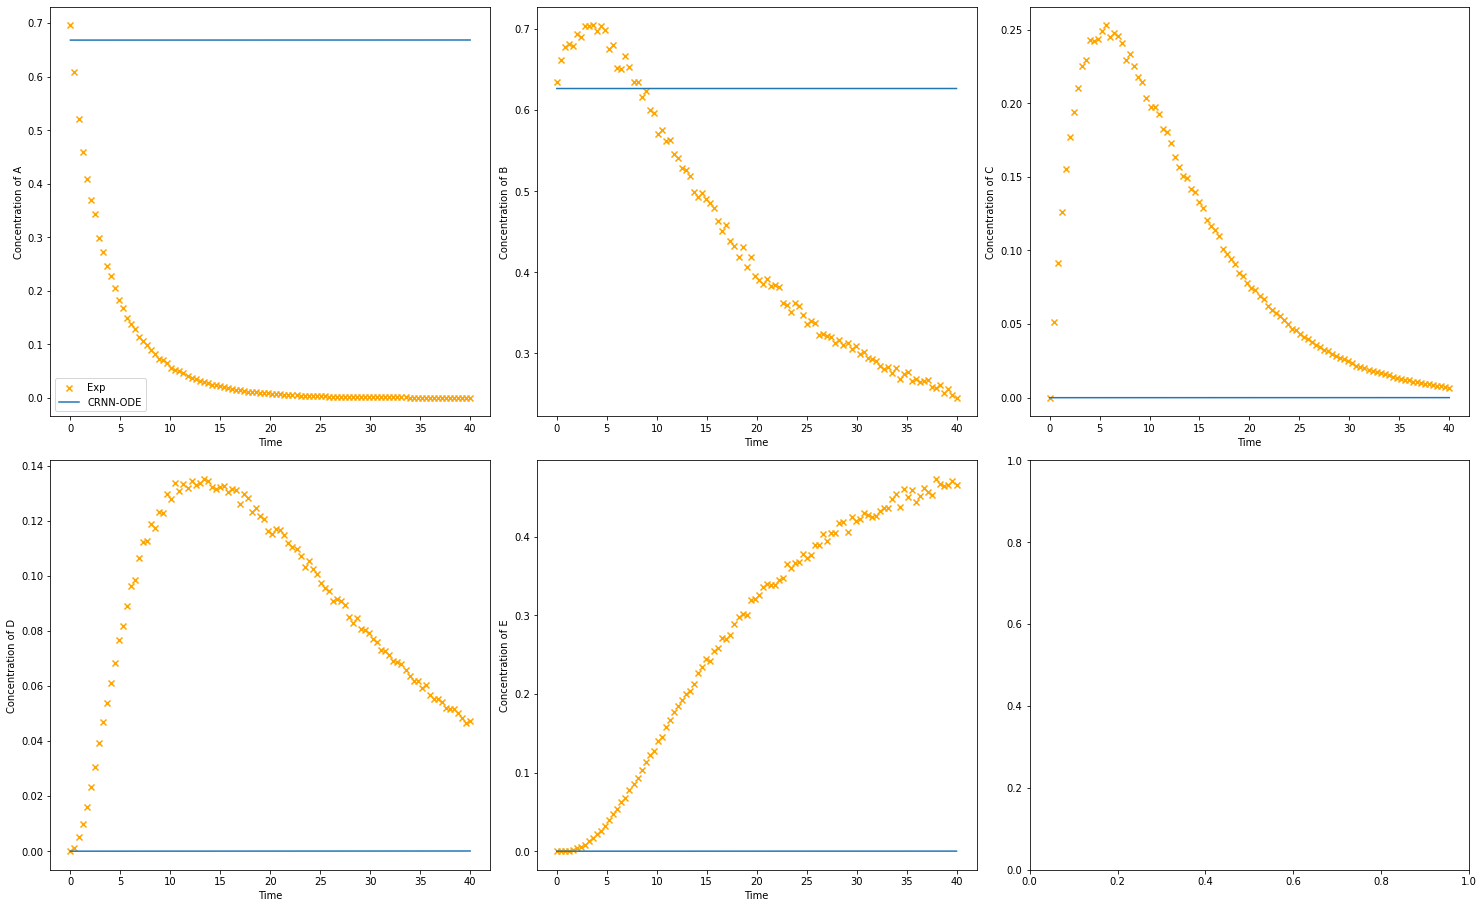

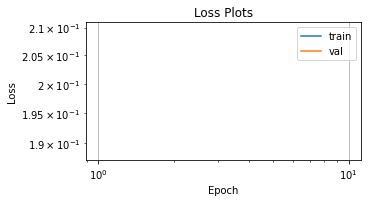

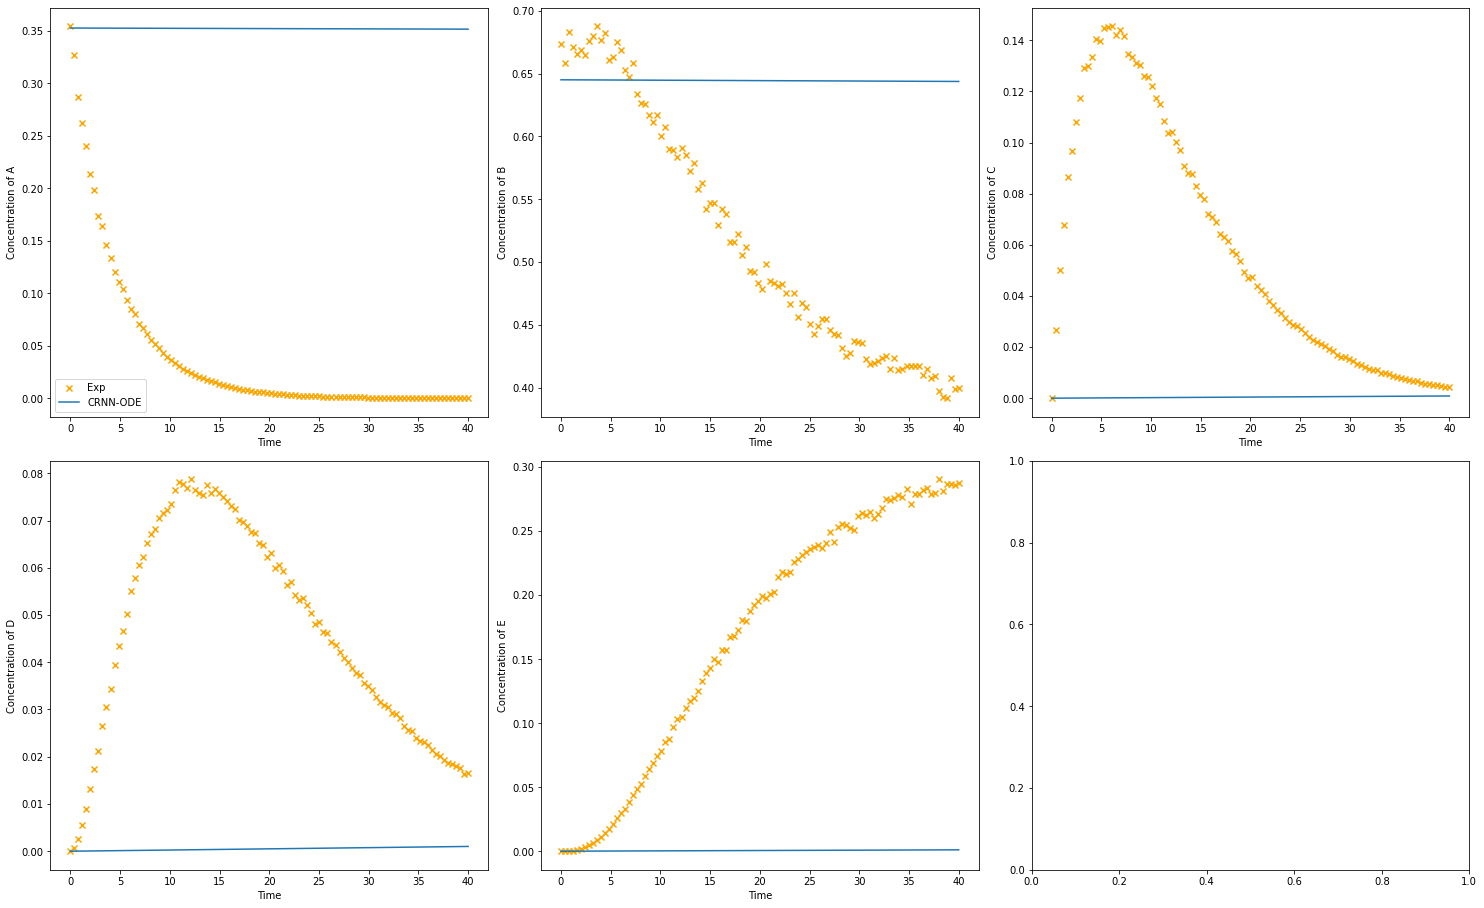

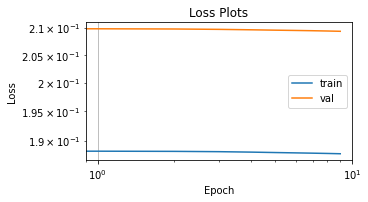

In [14]:
main()